Reference trajectory generation in driving, step 1, corner cutting as in 4DCHA

In [1]:
import numpy as np
import sympy as sp
from scipy.integrate import odeint
from control import TransferFunction, tf2ss, forced_response
from matplotlib import pyplot as plt

# test signal curvature, no clothoids
dt = 0.1                      # time base [s]
T = 10                        # time in curve [s]
t = np.arange(0, 2.5*T, dt)   # time vector
Kturn = np.pi/20              # turn rate [rad/s]
k = np.zeros(t.shape)         # turn rate vector
k[(t>0.5*T) * (t<=1.5*T)] = np.pi/20 
V = 10                        # velocity
X0 = V*T/2                    # distance before turn
R = V/(Kturn)                 # turn radius
ay = V**2/R                   # lateral acceleration
print(ay, R)

1.5707963267948966 63.66197723675813


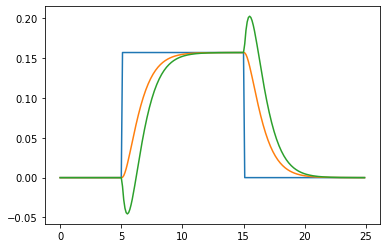

In [2]:
s = TransferFunction.s
tau = 0.8
taunm = -1.0

# H1, linear filter, 2nd order, as in 4DCHA 
H1 = 1/(tau*s + 1)**2
H2 = (1+taunm*s)/(tau*s + 1)**2
t, y1, x1 = forced_response(H1, t, k)
t, y2, x2 = forced_response(H2, t, k)

plt.plot(t, k, t, y1, t, y2)

(-6.52734929742557, 155.8486432334578, -7.380726933221971, 154.9952655976614)

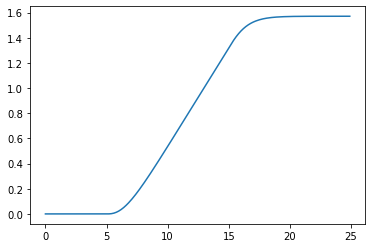

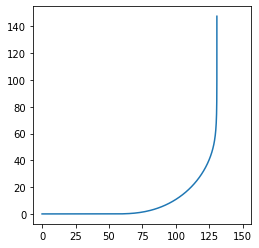

In [3]:
# now integrate and show curvature
sys1 = tf2ss(H1)
def ifunction(y, t, ksys, curve, V):
    dy = np.zeros(y.shape)
    u_k = curve(t)
    dy[0] = ksys.C @ y[3:] + ksys.D * u_k  # dot(psi)
    dy[1] = V * np.cos(y[0])
    dy[2] = V * np.sin(y[0])
    dy[3:] = (ksys.A @ y[3:].reshape((-1,1)) + ksys.B * u_k).squeeze()
    return dy

def curve(t):
    if t < 0.5*T or t >= 1.5*T:
        return 0.0
    return np.pi/20

y = odeint(ifunction, np.zeros(5), t, args=(sys1, curve, V))

plt.plot(t, y[:,0])
plt.figure()
plt.plot(y[:,1], y[:,2])
plt.axis('square')

time correction 1.6870709686948047


(-23.398058984373616,
 120.2036255589889,
 -8.133098723511308,
 170.79507319373744)

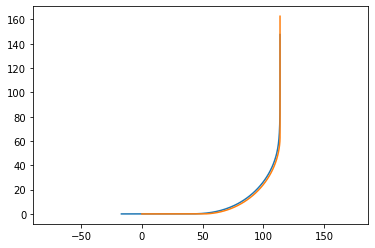

In [4]:
# calculate the road, perfect curve in this case
def ifunction_ref(y, t, curve, V):
    dy = np.zeros(y.shape)
    u_k = curve(t)
    dy[0] = u_k                 # dot(psi)
    dy[1] = V * np.cos(y[0])
    dy[2] = V * np.sin(y[0])
    return dy

yref = odeint(ifunction_ref, np.zeros(3), t, args=(curve,V))

# timing correction, calculated after the fact, simply "fit" the realized
# curve in
y1 = y[:,2]
yr = yref[:,2]
dxr4 = y[y1>100,1][0] - yref[yr>100,1][0]
print(f"time correction {dxr4/V}")

# prlot the corner cutting line (blue) with road ref (orange)
plt.plot(y[:,1]-dxr4, y[:,2], yref[:,1], yref[:,2])
plt.axis('equal')

time correction 2.613498056293365


(-33.125265248258486,
 120.66099782888789,
 -8.569201186067895,
 170.8158399776687)

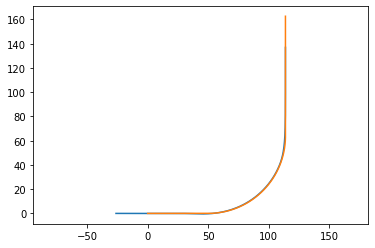

In [5]:
# curvature filtering with a non-minimum-phase zero
# swings wide, then cuts corner
sys2 = tf2ss(H2)

yw = odeint(ifunction, np.zeros(5), t, args=(sys2, curve, V))

# timing correction
y1 = yw[:,2]
yr = yref[:,2]
dxrw = yw[y1>100,1][0] - yref[yr>100,1][0]
print(f"time correction {dxrw/V}")

plt.plot(yw[:,1]-dxrw, yw[:,2], yref[:,1], yref[:,2])
plt.axis('equal')


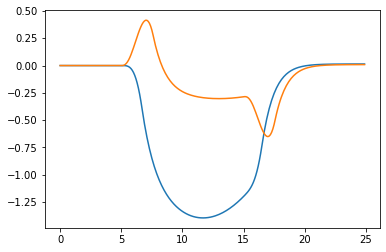

In [6]:
# calculates lateral position from straigt-circle-straight
def lateral(ypts, dxr):
    res = np.zeros(ypts.shape[0])
    for i, (x, y) in enumerate(ypts[:,1:3]):
        if x-dxr < X0:
            res[i] = -y
        elif y > R:
            res[i] = x - dxr - R - X0
        else:
            res[i] = np.sqrt((x-dxr-X0)**2 + (y-R)**2) - R
    return res

# plot lateral position of both tracks
l4 = lateral(y, dxr4)
lw = lateral(yw, dxrw)
plt.plot(t, l4, t, lw)